## 1.Import python packages

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

In [2]:
import pyodbc
import urllib
import sqlalchemy
'''destination databases'''
params_datahub = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")
engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

In [3]:
directoryPath=r"  "
df_engagement=pd.read_csv(directoryPath+'engagement_data.csv')
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   TIMESTAMP_EST               99989 non-null  object
 1   USER_ID_FIRST_PARTY_COOKIE  99989 non-null  object
 2   VISIT_ID                    99989 non-null  object
 3   ARTICLE_NUMBER              57060 non-null  object
 4   ARTICLE_HEADLINE            57060 non-null  object
 5   SECTION                     99985 non-null  object
 6   PAGE_NAME                   99989 non-null  object
 7   COUNTRY                     99939 non-null  object
 8   REGION_NAME                 83841 non-null  object
 9   OS_FAMILY                   99989 non-null  object
 10  REFERRER_DOMAIN             26596 non-null  object
 11  REFERRER_TYPE               99989 non-null  object
 12  ACCOUNT_TYPE                99989 non-null  object
 13  EVENT_CATEGORY              99989 non-null  ob

###### Data Cleanse: Drop 4 Null value in column "Section"

In [4]:
df_engagement[df_engagement['SECTION'].isnull()]
df_engagement2 = df_engagement.dropna(subset = ['SECTION'])
df_engagement2['TIMESTAMP_EST'] = df_engagement2['TIMESTAMP_EST'].apply(pd.to_datetime)
df_engagement2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99985 entries, 0 to 99988
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   TIMESTAMP_EST               99985 non-null  datetime64[ns]
 1   USER_ID_FIRST_PARTY_COOKIE  99985 non-null  object        
 2   VISIT_ID                    99985 non-null  object        
 3   ARTICLE_NUMBER              57060 non-null  object        
 4   ARTICLE_HEADLINE            57060 non-null  object        
 5   SECTION                     99985 non-null  object        
 6   PAGE_NAME                   99985 non-null  object        
 7   COUNTRY                     99935 non-null  object        
 8   REGION_NAME                 83838 non-null  object        
 9   OS_FAMILY                   99985 non-null  object        
 10  REFERRER_DOMAIN             26596 non-null  object        
 11  REFERRER_TYPE               99985 non-null  object    

df_engagement2 is section without null vlaue and timestamp datatype as time

In [5]:
df_engagement2.to_csv(directoryPath+'engagement_data2.csv',index=False)

In [6]:
df_globescore=pd.read_csv(directoryPath+'globescore_data.csv')
df_globescore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37366 entries, 0 to 37365
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ARTICLE_NUMBER  37366 non-null  object
 1   BYLINE          31777 non-null  object
 2   PUBLISHEDAT     37366 non-null  object
 3   GLOBESCORE      37366 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


In [7]:
# drop null values article numbers in globe score.
df_globescore_author = df_globescore.dropna(subset=['BYLINE'])
df_globescore_author.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31777 entries, 0 to 37365
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ARTICLE_NUMBER  31777 non-null  object
 1   BYLINE          31777 non-null  object
 2   PUBLISHEDAT     31777 non-null  object
 3   GLOBESCORE      31777 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [8]:
# df_globescore_author.to_csv(directoryPath+'globescore_data_author.csv',index=False)

#### Update the file in the SQL from csv

In [9]:
import glob
directoryPath=r"  "

# for file_name in glob.glob(directoryPath+'*.csv'):
#         print(Path(file_name).stem)
#         x = pd.read_csv(file_name)
#         x.to_sql(Path(file_name).stem, engine_datahub,if_exists='replace',index=False)

###### 1.What is the average Globe score and total Globe score for each section? Order by highest average Globe score.

In [10]:
df_globescore_measure = pd.DataFrame(df_globescore.groupby('ARTICLE_NUMBER').agg({'GLOBESCORE':[np.mean,np.sum]})).reset_index()
df_globescore_measure

ARTICLE_NUMBER GLOBESCORE    
                                                  mean sum
0      00148faf-f022-41ff-b8bc-9fad0e0fb87e       73.0  73
1      0278c0f9-dfb4-486b-9c51-c77d5ff3581b       94.0  94
2      02a08c79-58df-4cfc-8720-f11681f0fbce       79.0  79
3      02e8008c-eb68-41b6-95d9-0713c780e5ab       63.0  63
4      0535a511-3c09-4353-8074-0f870f08e0cd       69.0  69
...                                     ...        ...  ..
37361  fdf2aa02-c6bf-4316-8487-aa7af6690780       59.0  59
37362  fdff5609-4119-4b32-acf2-55118759ef3b       45.0  45
37363  fe7ca030-5922-4224-a5ac-e57d2827da5a       78.0  78
37364  febd0b75-fac4-4d21-95d0-66caaea903e1       96.0  96
37365  fedc0aa1-a7c0-4a01-99dc-7d0adea0237f       27.0  27

[37366 rows x 3 columns]

In [11]:
# one article has one scores. to calculate the average score per article
df_globescore_mean = pd.DataFrame(df_globescore.groupby('ARTICLE_NUMBER')['GLOBESCORE'].mean()).reset_index()
average_globalscore = round(df_globescore_mean['GLOBESCORE'].mean(),0)
print("The average score per article is {}".format(average_globalscore))

The average score per article is 50.0


In [12]:
df_article_score = pd.merge(df_engagement2,df_globescore_mean,on = 'ARTICLE_NUMBER',how = 'inner')
df_article_score.query("ARTICLE_NUMBER=='O5TMKDY4PZANHOORV3DT62KHJU'")

,TIMESTAMP_EST,USER_ID_FIRST_PARTY_COOKIE,VISIT_ID,ARTICLE_NUMBER,ARTICLE_HEADLINE,SECTION,PAGE_NAME,COUNTRY,REGION_NAME,OS_FAMILY,REFERRER_DOMAIN,REFERRER_TYPE,ACCOUNT_TYPE,EVENT_CATEGORY,EVENT_ID,WALL_TYPE,EVENT_LABEL,DEVICE_TYPE,PAGE_TYPE,GLOBESCORE
134,2022-09-01 12:33:28.941,fe99ee19-7f21-ea16-3d9c-2b54c9bb87c9,503e2b33-9d6f-c12c-c8d3-cde68993c4f8,O5TMKDY4PZANHOORV3DT62KHJU,Russia’s looming defeat in Ukraine,opinion,opinion:article,US,New York,iOS,Google,search,Anonymous User,pageView,b297dd5a-ae7b-441e-b79f-6be20a01274d,regwall,https://www.theglobeandmail.com/opinion/articl...,Mobile,article,79.0
135,2022-09-01 06:35:55.977,80db5226-a4cc-4caa-92c9-5662438b7b21,50a23e3a-3985-49ad-9104-00836a02a23c,O5TMKDY4PZANHOORV3DT62KHJU,Russia’s looming defeat in Ukraine,opinion,opinion:article,US,California,Windows,Bing,search,Anonymous User,pageView,a59f4c39-d318-491e-98b4-2aa961b3b5d0,regwall,/opinion/article-russia-ukraine-war-defeat/,Computer,article,79.0


<AxesSubplot:title={'center':'Averge Global Score per Section'}, xlabel='Section', ylabel='Average Score'>

<Figure size 1080x432 with 0 Axes>

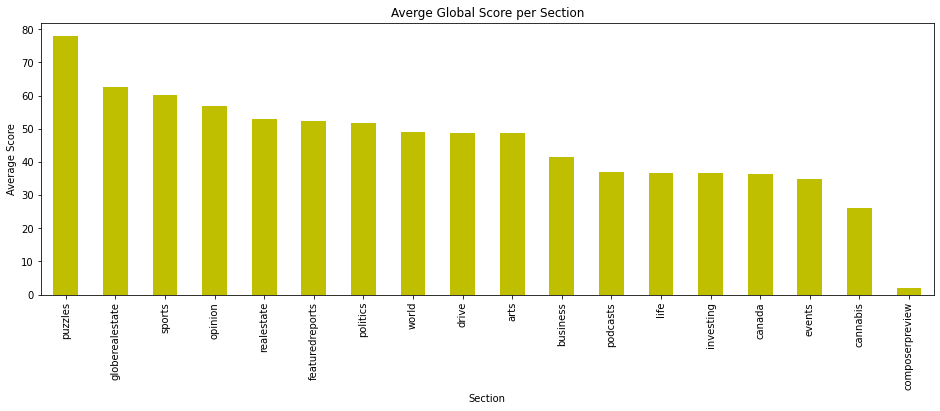

In [13]:
plt.figure(figsize=(15,6))
df_article_score.groupby('SECTION').agg({'GLOBESCORE':'mean'}).sort_values(by='GLOBESCORE',ascending = False).plot(kind='bar', figsize=(16,5), title='Averge Global Score per Section',
             xlabel='Section', ylabel='Average Score', legend=False, color='y')

In [14]:
df_globescore_sum = pd.DataFrame(df_globescore.groupby('ARTICLE_NUMBER')['GLOBESCORE'].sum()).reset_index()

<AxesSubplot:title={'center':'Total Global Score per Section'}, xlabel='Section', ylabel='Total Score'>

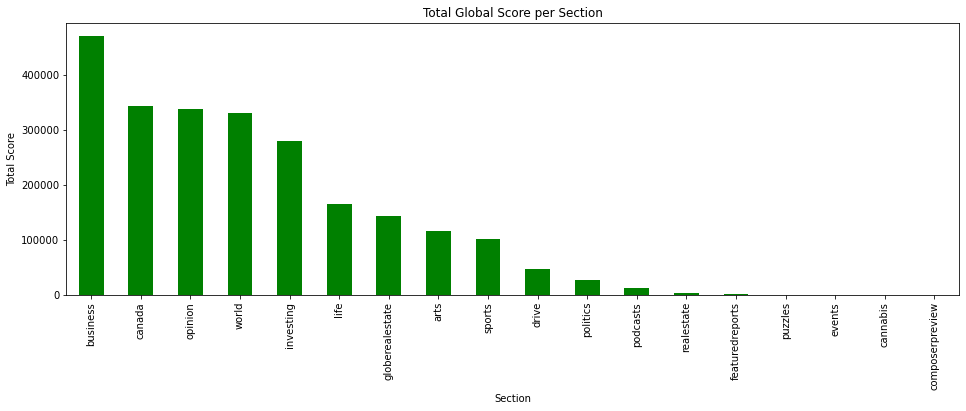

In [15]:
df_article_score.groupby('SECTION').agg({'GLOBESCORE':'sum'}).sort_values(by='GLOBESCORE',ascending = False).plot(kind='bar', figsize=(16,5), title='Total Global Score per Section',
             xlabel='Section', ylabel='Total Score', legend=False,color='g')

###### 2.What is average time on page for articles and section pages by section name?

In [16]:
df_engagement[df_engagement['ARTICLE_NUMBER'].isnull()]
df_engagement_article = df_engagement.dropna(subset = ['ARTICLE_NUMBER'])
df_engagement_article['TIMESTAMP_EST'] = df_engagement_article['TIMESTAMP_EST'].apply(pd.to_datetime)
df_engagement_article.info()
## find all the rows without null article_number value

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57060 entries, 0 to 99988
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   TIMESTAMP_EST               57060 non-null  datetime64[ns]
 1   USER_ID_FIRST_PARTY_COOKIE  57060 non-null  object        
 2   VISIT_ID                    57060 non-null  object        
 3   ARTICLE_NUMBER              57060 non-null  object        
 4   ARTICLE_HEADLINE            57060 non-null  object        
 5   SECTION                     57060 non-null  object        
 6   PAGE_NAME                   57060 non-null  object        
 7   COUNTRY                     57029 non-null  object        
 8   REGION_NAME                 47487 non-null  object        
 9   OS_FAMILY                   57060 non-null  object        
 10  REFERRER_DOMAIN             23024 non-null  object        
 11  REFERRER_TYPE               57060 non-null  object    

In [17]:
#Pandas equivalent of SQL except
# df_engagement_article_pagename_event_min_test = df_engagement_article_pagename_event_min.drop('PAGE_NAME',axis=1)
# ~df_engagement_article_event_min.isin(df_engagement_article_pagename_event_min_test).all(axis=1)

In [18]:
df_engagement_article_pagename_event = pd.DataFrame(df_engagement_article.groupby(['USER_ID_FIRST_PARTY_COOKIE','VISIT_ID','PAGE_NAME','EVENT_ID']).agg({'TIMESTAMP_EST':'max'})).reset_index()
df_engagement_article_pagename_event_max = pd.DataFrame(df_engagement_article_pagename_event.groupby(['USER_ID_FIRST_PARTY_COOKIE','VISIT_ID','PAGE_NAME'])['TIMESTAMP_EST'].max()).reset_index()
df_engagement_article_pagename_event_min= pd.DataFrame(df_engagement_article_pagename_event.groupby(['USER_ID_FIRST_PARTY_COOKIE','VISIT_ID','PAGE_NAME'])['TIMESTAMP_EST'].min()).reset_index()
# df_engagement_article_pagename_event_min

In [19]:
df_engagement_article_pagename_event_time = pd.merge(df_engagement_article_pagename_event_max,df_engagement_article_pagename_event_min,on = ['USER_ID_FIRST_PARTY_COOKIE','VISIT_ID','PAGE_NAME'],how = 'inner')
df_engagement_article_pagename_event_time = df_engagement_article_pagename_event_time.rename({'TIMESTAMP_EST_x':'TIMESTAMP_EST_max','TIMESTAMP_EST_y':'TIMESTAMP_EST_min'},axis=1)

In [20]:
df_engagement_article_pagename_event_time['TIMESTAMP_EST_DIFF'] = df_engagement_article_pagename_event_time['TIMESTAMP_EST_max']-df_engagement_article_pagename_event_time['TIMESTAMP_EST_min']
df_engagement_article_pagename_event_time.head(1)

,USER_ID_FIRST_PARTY_COOKIE,VISIT_ID,PAGE_NAME,TIMESTAMP_EST_max,TIMESTAMP_EST_min,TIMESTAMP_EST_DIFF
0,0000176b-12c4-4914-9e43-fec8baada721,50b243f3-6ba2-4608-a93b-1d3a513f7262,community:digitallab:article,2022-09-01 10:27:27.826,2022-09-01 10:27:27.826,0 days


In [22]:
average_time_article_pagename = df_engagement_article_pagename_event_time['TIMESTAMP_EST_DIFF'].mean()
print('The averge time on page for articles is {}'.format(average_time_article_pagename))

The averge time on page for articles is 0 days 00:00:43.204776214


In [23]:
# df_engagement_article_event_time.query("TIMESTAMP_EST_DIFF=='0 days 06:23:31.885000'")
# df_engagement_article_event_time = df_engagement_article_event_time.drop(labels =5352,axis=0)

In [24]:
df_engagement_section_pagename_max = pd.DataFrame(df_engagement2.groupby(['USER_ID_FIRST_PARTY_COOKIE','VISIT_ID','SECTION','PAGE_NAME']).agg({'TIMESTAMP_EST':'max'})).reset_index()
# df_engagement_section_max.query("VISIT_ID=='bb353870-f6e5-4732-afdd-5bb19f584e1a'")
df_engagement_section_pagename_min = pd.DataFrame(df_engagement2.groupby(['USER_ID_FIRST_PARTY_COOKIE','VISIT_ID','SECTION','PAGE_NAME']).agg({'TIMESTAMP_EST':'min'})).reset_index()
df_engagement_section_pagename= pd.merge(df_engagement_section_pagename_max,df_engagement_section_pagename_min,on = ['USER_ID_FIRST_PARTY_COOKIE','VISIT_ID','SECTION','PAGE_NAME'],how = 'inner')
df_engagement_section_pagename = df_engagement_section_pagename.rename({'TIMESTAMP_EST_x':'TIMESTAMP_EST_max','TIMESTAMP_EST_y':'TIMESTAMP_EST_min'},axis=1)
df_engagement_section_pagename['TIMESTAMP_EST_DIFF'] = df_engagement_section_pagename['TIMESTAMP_EST_max']-df_engagement_section_pagename['TIMESTAMP_EST_min']
df_engagement_section_pagename.head(1)

,USER_ID_FIRST_PARTY_COOKIE,VISIT_ID,SECTION,PAGE_NAME,TIMESTAMP_EST_max,TIMESTAMP_EST_min,TIMESTAMP_EST_DIFF
0,0000176b-12c4-4914-9e43-fec8baada721,50b243f3-6ba2-4608-a93b-1d3a513f7262,canada,canada:section,2022-09-01 10:29:53.666,2022-09-01 10:29:53.666,0 days


In [25]:
df_engagement_section_pagename_avg_time = pd.DataFrame(df_engagement_section_pagename.groupby('SECTION')['TIMESTAMP_EST_DIFF'].mean().sort_values(ascending = False))
df_engagement_section_pagename_avg_time['TIMESTAMP_EST_DIFF_MINUTES'] = df_engagement_section_pagename_avg_time['TIMESTAMP_EST_DIFF'] / pd.Timedelta(minutes=1)
df_engagement_section_pagename_avg_time.head()

,TIMESTAMP_EST_DIFF,TIMESTAMP_EST_DIFF_MINUTES
SECTION,,
homepage,0 days 00:03:00.412649671,3.006877
search,0 days 00:02:29.333572519,2.488893
reportanerror,0 days 00:02:18.795500,2.313258
featuredreports,0 days 00:02:15.841866666,2.264031
puzzles,0 days 00:02:01.270759292,2.021179


In [26]:
average_time_section_pagename = df_engagement_section_pagename_avg_time['TIMESTAMP_EST_DIFF'].mean()
print("The average time on section pages by section is {}".format(average_time_section_pagename))

The average time on section pages by section is 0 days 00:00:31.527996796


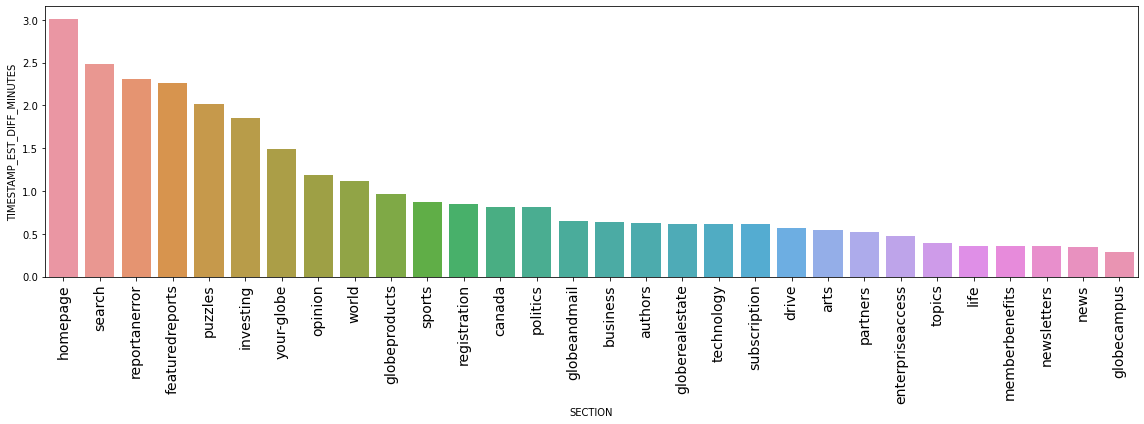

In [27]:
df_engagement_section_pagename_avg_time_top = df_engagement_section_pagename_avg_time.head(30)
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x=df_engagement_section_pagename_avg_time_top.index,y = 'TIMESTAMP_EST_DIFF_MINUTES', data = df_engagement_section_pagename_avg_time_top)
plt.xticks(rotation=90,size = 14)
plt.tight_layout()

In [28]:
# df_engagement_section_pagename_avg_time

In [29]:
# df_engagement_section.info()
# df_engagement_section_pagename_test = df_engagement_section_pagename.drop('PAGE_NAME',axis=1)
# df_engagement_section[~df_engagement_section.isin(df_engagement_section_pagename_test).all(axis=1)]

###### 3.What is the page bounce rate by section name? 
Bounce rate (%) = Visits that access only a single page (#) ÷ Total visits (#) to the website

Hits measure activity from the website server's perspective. 
Page Views are a measure of how humans, not computers, are interacting with your website. 
:section in page_name are considered as single page

In [30]:
#fuzzy query
# df_engagement_pageview.query('PAGE_NAME.str.contains(":section")',engine='python')

In [32]:
df_engagement_section_pagename_count = pd.DataFrame(df_engagement2.groupby(['USER_ID_FIRST_PARTY_COOKIE','VISIT_ID','SECTION','PAGE_NAME'])['EVENT_ID'].count()).reset_index()
df_engagement_section_pagename_single_visit = pd.DataFrame(df_engagement_section_pagename_count.query("EVENT_ID==1").groupby('SECTION')['VISIT_ID'].count()).reset_index()
df_engagement_section_pagename_single_visit = df_engagement_section_pagename_single_visit.rename({'VISIT_ID':'SINGEL_VISIT_TIMES'},axis=1)
# df_engagement_section_pagename_single_visit.head(1)

In [33]:
df_engagement_section_pagename_total_visit = pd.DataFrame(df_engagement_section_pagename_count.groupby('SECTION')['VISIT_ID'].count()).reset_index()
df_engagement_section_pagename_total_visit = df_engagement_section_pagename_total_visit.rename({'VISIT_ID':'TOTAL_VISIT_TIMES'},axis=1)
# df_engagement_section_pagename_total_visit.head(1)

In [34]:
df_engagement_section_pagename_bounce = pd.merge(df_engagement_section_pagename_total_visit,df_engagement_section_pagename_single_visit,on = 'SECTION',how = 'left').fillna(0)
df_engagement_section_pagename_bounce['BOUNCE_RATE'] = round(df_engagement_section_pagename_bounce['SINGEL_VISIT_TIMES']/df_engagement_section_pagename_bounce['TOTAL_VISIT_TIMES'],2)
df_engagement_section_pagename_bounce = df_engagement_section_pagename_bounce.sort_values(by = 'BOUNCE_RATE',ascending = False)
# Bounce rate per section

,SECTION,TOTAL_VISIT_TIMES,SINGEL_VISIT_TIMES,BOUNCE_RATE
24,globeinvestor,35,35,1.0
13,composerpreview,1,1,1.0
37,newsrelease,18,18,1.0
40,originals,3,3,1.0
34,multimedia,3,3,1.0


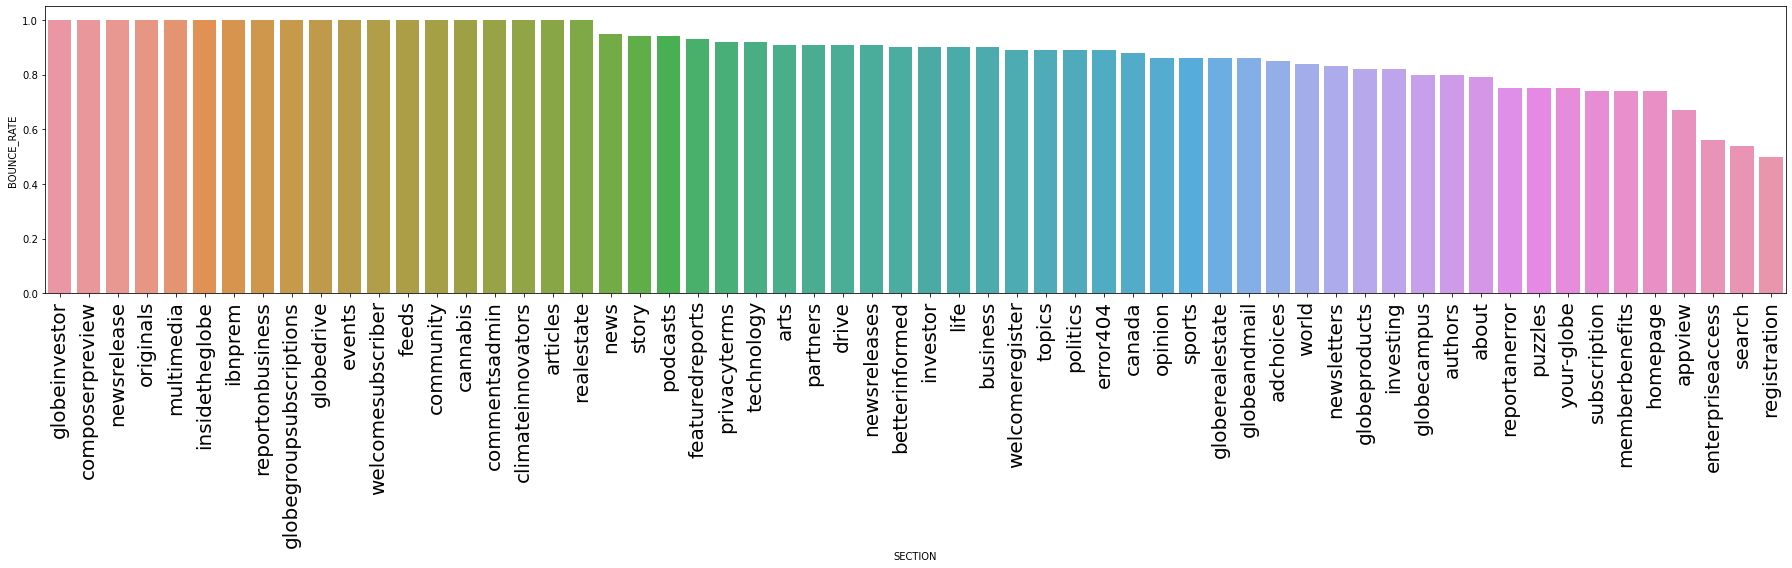

In [35]:
fig, ax = plt.subplots(figsize=(25, 8))
sns.barplot(x=df_engagement_section_pagename_bounce['SECTION'],y = 'BOUNCE_RATE', data = df_engagement_section_pagename_bounce)
plt.xticks(rotation=90, size = 20)
plt.tight_layout()
df_engagement_section_pagename_bounce.head(5)

###### 4.What is the bounce rate for wall encounters? Is the bounce rate different for paywalls and registration walls?

A paywall blockes access to content, requiring a reader to pay to subscribe before they can pass. 

A registration wall also blocks access to content, but a reader will simply have to create a free account on the website 
before they can get past.

In [36]:
df_engagement_paywall = df_engagement.query("WALL_TYPE=='paywall'")

In [37]:
df_engagement_paywall_event_count = pd.DataFrame(df_engagement_paywall.groupby(['USER_ID_FIRST_PARTY_COOKIE','VISIT_ID']).agg({'TIMESTAMP_EST':'count'})).reset_index()
df_engagement_paywall_event_count = df_engagement_paywall_event_count.rename({'TIMESTAMP_EST':'VISIT_TIMES'},axis = 1)
# df_engagement_paywall_event_count.query("VISIT_ID =='4c8f57a4-3b1b-493b-96e0-406acc991718'")

In [38]:
df_engagement_paywall_event_single_visit = df_engagement_paywall_event_count.query("VISIT_TIMES==1")
#153 rows
single_visit_paywall = df_engagement_paywall_event_single_visit['VISIT_TIMES'].count()
print("There are {} single visits in paywall type".format(single_visit_paywall))
total_visit_paywall = df_engagement_paywall_event_count['VISIT_TIMES'].sum()
print("There are {} total visits in paywall type".format(total_visit_paywall))
bounce_rate_paywall = round(single_visit_paywall/total_visit_paywall,2)
print("Bounce rate for paywall is {}".format(bounce_rate_paywall ))

There are 153 single visits in paywall type
There are 167 total visits in paywall type
Bounce rate for paywall is 0.92


In [39]:
df_engagement_regwall = df_engagement.query("WALL_TYPE=='regwall'")

In [40]:
df_engagement_regwall_event_count = pd.DataFrame(df_engagement_regwall.groupby(['USER_ID_FIRST_PARTY_COOKIE','VISIT_ID']).agg({'TIMESTAMP_EST':'count'})).reset_index()
df_engagement_regwall_event_count = df_engagement_regwall_event_count.rename({'TIMESTAMP_EST':'VISIT_TIMES'},axis = 1)

In [41]:
df_engagement_regwall_event_single_visit = df_engagement_regwall_event_count.query("VISIT_TIMES==1")
single_visit_regwall = df_engagement_regwall_event_single_visit['VISIT_TIMES'].count()
print("There are {} single visits in regwall type".format(single_visit_regwall))
total_visit_regwall = df_engagement_regwall_event_count['VISIT_TIMES'].sum()
print("There are {} total visits in regwall type".format(total_visit_regwall))
bounce_rate_regwall = round(single_visit_regwall/total_visit_regwall,2)
print("Bounce rate for regwall is {}".format(bounce_rate_regwall ))

There are 36741 single visits in regwall type
There are 99822 total visits in regwall type
Bounce rate for regwall is 0.37


###### 5.What are the top referrer domains by the number of total pageviews they brought, based on first-click attribution model

First-click attribution is a single-touch attribution model where 100% of the credit for a sale is assigned to the first touchpoint in the customer’s path to purchase.

In [42]:
df_engagement_pageview = df_engagement.query("EVENT_CATEGORY=='pageView'")

In [43]:
df_pageview_referrer_domain = pd.DataFrame(df_engagement_pageview.groupby(['REFERRER_DOMAIN','REFERRER_TYPE'],dropna=False).agg({'TIMESTAMP_EST':'min','EVENT_ID':'nunique'})).reset_index()
df_pageview_referrer_domain = df_pageview_referrer_domain.sort_values(by='EVENT_ID',ascending = False)
df_pageview_referrer_domain.head(10)

,REFERRER_DOMAIN,REFERRER_TYPE,TIMESTAMP_EST,EVENT_ID
22,NaN,internal,2022-09-01 00:06:59.591,36980
21,NaN,direct,2022-09-01 00:00:28.797,33168
7,Google,search,2022-09-01 00:01:12.801,13987
9,Google News,search,2022-09-01 00:00:55.265,5009
4,Facebook,social,2022-09-01 00:38:14.772,4053
24,NaN,unknown,2022-09-01 00:05:44.492,2314
17,Twitter,social,2022-09-01 00:21:06.735,2017
0,Bing,search,2022-09-01 01:52:52.034,399
16,Reddit,social,2022-09-01 07:50:06.220,225
13,LinkedIn,social,2022-09-01 05:54:24.090,220


In [44]:
df_pageview_referrer_domain_top = df_pageview_referrer_domain.dropna(subset=['REFERRER_DOMAIN']).head()
df_pageview_referrer_domain_top

,REFERRER_DOMAIN,REFERRER_TYPE,TIMESTAMP_EST,EVENT_ID
7,Google,search,2022-09-01 00:01:12.801,13987
9,Google News,search,2022-09-01 00:00:55.265,5009
4,Facebook,social,2022-09-01 00:38:14.772,4053
17,Twitter,social,2022-09-01 00:21:06.735,2017
0,Bing,search,2022-09-01 01:52:52.034,399


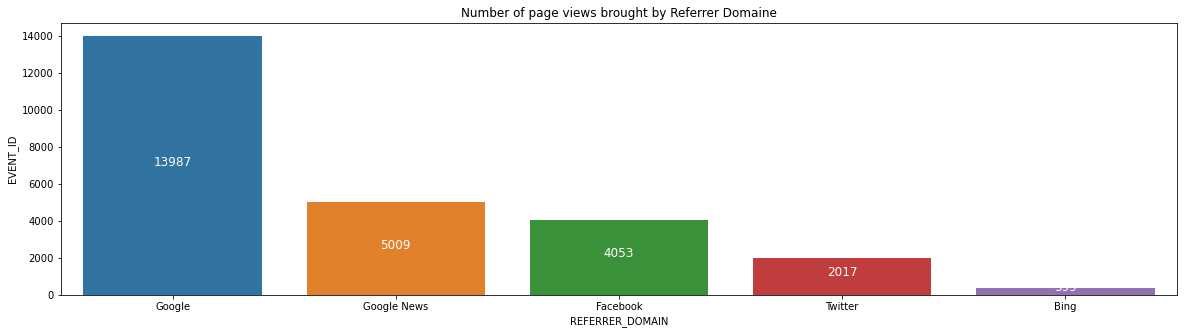

In [45]:
fig, ax = plt.subplots(figsize=(20, 5))

bar = sns.barplot(data = df_pageview_referrer_domain_top,x=df_pageview_referrer_domain_top['REFERRER_DOMAIN'],y = df_pageview_referrer_domain_top['EVENT_ID'])
bar.set(title='Number of page views brought by Referrer Domaine')

num_user_referrer_domaine = df_pageview_referrer_domain_top['EVENT_ID'].to_list()
for i in range(len(num_user_referrer_domaine)):
    bar.text(i,num_user_referrer_domaine[i]/2,str(round(num_user_referrer_domaine[i],2)),
             fontdict = dict(color='white',fontsize=12),
             horizontalalignment = 'center')

###### How many subscriptions were there in total?

Approach 1: filter page type subscription then calculate distinct user id

In [46]:
df_engagement_subscription = df_engagement.query("PAGE_TYPE=='subscription'")
number_of_subscriptions = df_engagement_subscription['USER_ID_FIRST_PARTY_COOKIE'].nunique()
print("The subscription number is {}".format(number_of_subscriptions ))

The subscription number is 159


Approach 2: from Premium user and Registered user to find subscribed user to determine the subscription rate

In [47]:
df_engagement_user = pd.DataFrame(df_engagement.groupby(['USER_ID_FIRST_PARTY_COOKIE','ACCOUNT_TYPE'])['ACCOUNT_TYPE'].nunique().unstack().fillna(0)).reset_index()
df_engagement_user['Subscribed_User'] = df_engagement_user['Premium User'] + df_engagement_user['Registered User']

In [48]:
conversion_status = []
for n in range(len(df_engagement_user['USER_ID_FIRST_PARTY_COOKIE'])):
    if df_engagement_user['Anonymous User'][n] !=0 and df_engagement_user['Subscribed_User'][n] !=0:
        conversion_status.append('converted')
    elif df_engagement_user['Anonymous User'][n]== 0 and df_engagement_user['Subscribed_User'][n] !=0:
        conversion_status.append('existing subscription')
    else:
        conversion_status.append('no conversion')
df_engagement_user['conversion_status'] = conversion_status
df_engagement_user.head(5)      

ACCOUNT_TYPE,USER_ID_FIRST_PARTY_COOKIE,Anonymous User,Premium User,Registered User,Subscribed_User,conversion_status
0,0000176b-12c4-4914-9e43-fec8baada721,1.0,0.0,0.0,0.0,no conversion
1,00012d65-961e-4cde-a9d8-fe0d36c6863f,1.0,0.0,0.0,0.0,no conversion
2,00029fc8-c1ce-48da-bd38-34f813080146,1.0,0.0,0.0,0.0,no conversion
3,0004e2b6-0511-4c3c-9b78-9d909cda48ef,0.0,1.0,0.0,1.0,existing subscription
4,00056a25-4269-44d6-b60b-ae465725c4eb,1.0,0.0,0.0,0.0,no conversion


In [49]:
df_engagement_user_conversion_status = pd.DataFrame(df_engagement_user.groupby('conversion_status')['USER_ID_FIRST_PARTY_COOKIE'].nunique().sort_values(ascending=False)).reset_index()
df_engagement_user_conversion_status = df_engagement_user_conversion_status.set_index('conversion_status')

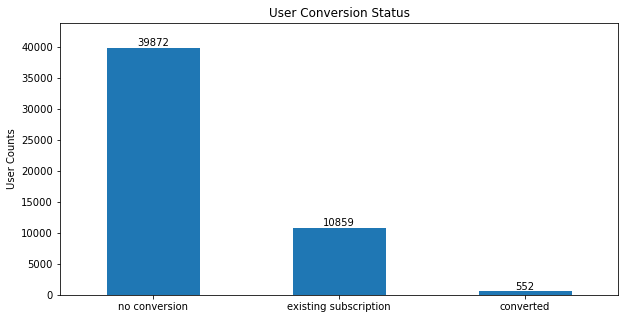

In [50]:
ax = df_engagement_user_conversion_status.plot(kind='bar', figsize=(10,5), rot=0, title='User Conversion Status',
             xlabel = "",ylabel='User Counts', legend=False)

ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)

In [51]:
total_user_count = df_engagement['USER_ID_FIRST_PARTY_COOKIE'].nunique()
print('There are {} total users'.format(total_user_count))
subscribed_user_count = df_engagement_user.query("Subscribed_User!=0.0")['USER_ID_FIRST_PARTY_COOKIE'].nunique()
print("{} subscriptions among them".format(subscribed_user_count))
subscription_rate = round(subscribed_user_count/total_user_count,3)
print("Subscription rate is {}".format(subscription_rate))

There are 51283 total users
11411 subscriptions among them
Subscription rate is 0.223


###### What was the paywall conversion rate?

Approach 1: use page type subscription and paywall to filter the data then get distinct user id, result is 0

In [52]:
df_engagement_subscription_paywall = df_engagement.query("PAGE_TYPE=='subscription'& WALL_TYPE=='paywall'")
number_of_paywall_subscriptions = df_engagement_subscription_paywall['USER_ID_FIRST_PARTY_COOKIE'].nunique()
print("The subscription number is {}".format(number_of_paywall_subscriptions))

The subscription number is 0


Approach 2: from Premium user and Registered user to find subscribed user to determine the subscription rate, result is also 0

In [53]:
df_paywall_users = pd.DataFrame(df_engagement_paywall.groupby(['USER_ID_FIRST_PARTY_COOKIE','ACCOUNT_TYPE'])['ACCOUNT_TYPE'].nunique().unstack().fillna(0)).reset_index()
df_paywall_users

ACCOUNT_TYPE,USER_ID_FIRST_PARTY_COOKIE,Anonymous User,Registered User
0,06d4ade8-cb53-44f1-9992-d6b0e2f577a5,1.0,0.0
1,0890b018-b420-4523-9221-6f3cd35c20e2,1.0,0.0
2,0a6dbe5e-755e-4b1d-aeec-03a097e23be1,1.0,0.0
3,0ae7b68c-a186-4175-b4d4-08d50e95e26b,1.0,0.0
4,0be86fc4-6977-4a5a-b416-2175c5ba4f2c,1.0,0.0
...,...,...,...
150,f4bb53ae-efa5-48da-a66c-c10aaf537b74,1.0,0.0
151,f7f1908f-be80-4159-b8b5-e5feec4f1eee,1.0,0.0
152,f81fd883-7860-4dcf-877c-dec34ca18830,1.0,0.0
153,fbba4e1c-4f2b-4ecb-93a1-ac4e7b4d6564,1.0,0.0


conversion_status_paywall
existing subscription      4
no conversion            151
Name: USER_ID_FIRST_PARTY_COOKIE, dtype: int64

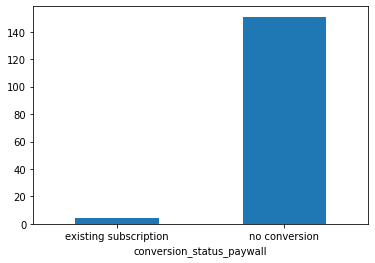

In [54]:
conversion_status_paywall = []
for m in range(len(df_paywall_users['USER_ID_FIRST_PARTY_COOKIE'])):
    if df_paywall_users['Anonymous User'][m] !=0 and df_paywall_users['Registered User'][m] !=0:
        conversion_status_paywall.append('converted')
    elif df_paywall_users['Anonymous User'][m]== 0 and df_paywall_users['Registered User'][m] !=0:
        conversion_status_paywall.append('existing subscription')
    else:
        conversion_status_paywall.append('no conversion')
df_paywall_users['conversion_status_paywall'] = conversion_status_paywall
df_paywall_users.groupby('conversion_status_paywall')['USER_ID_FIRST_PARTY_COOKIE'].nunique().plot(kind='bar',rot=0)
df_paywall_users.groupby('conversion_status_paywall')['USER_ID_FIRST_PARTY_COOKIE'].nunique()

There's no conversion in the paywall users. -- Reference from above: Bounce rate for paywall is 0.92

Paywall is high bounce rate without any user conversion

###### Create a page view data set containing Visitor ID and Account Type. 
Create a measure in Tableau that properly calculates page views for Visitor ID regardless of whether Account Type is present in the visualisation or not.

In [55]:
df_engagement_account_user_id_count = df_engagement2.groupby(['SECTION','ACCOUNT_TYPE'])['USER_ID_FIRST_PARTY_COOKIE'].count().unstack().fillna(0)
df_engagement_account_user_id_count['Total_User']= df_engagement_account_user_id_count['Anonymous User'] + df_engagement_account_user_id_count['Premium User'] + df_engagement_account_user_id_count['Registered User']
df_engagement_account_user_id_count = df_engagement_account_user_id_count.sort_values(['Total_User','Premium User','Registered User','Anonymous User'],ascending=[False,False,False,False])
df_engagement_account_user_id_count.head(10)

ACCOUNT_TYPE,Anonymous User,Premium User,Registered User,Total_User
SECTION,,,,
investing,8879.0,8623.0,1871.0,19373.0
homepage,6348.0,9838.0,694.0,16880.0
business,9156.0,3235.0,386.0,12777.0
canada,7363.0,2682.0,211.0,10256.0
world,4398.0,2844.0,174.0,7416.0
opinion,4222.0,2206.0,173.0,6601.0
life,4903.0,1057.0,179.0,6139.0
globeandmail,5122.0,116.0,65.0,5303.0
arts,1904.0,919.0,53.0,2876.0


In [56]:
df_engagement_account_user_id_count_top = df_engagement_account_user_id_count.head(10)
df_engagement_account_user_id_count_top.index

Index(['investing', 'homepage', 'business', 'canada', 'world', 'opinion',
       'life', 'globeandmail', 'arts', 'globerealestate'],
      dtype='object', name='SECTION')

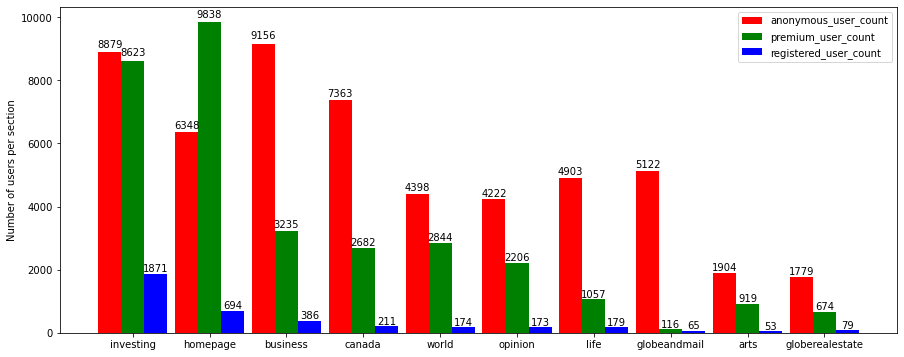

In [57]:
import numpy as np
import matplotlib.pyplot as plt
  
N = 10
ind = np.arange(N) 
width = 0.3
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
  
anonymous_user_count = df_engagement_account_user_id_count_top['Anonymous User'].to_list()
rects1 = ax.bar(ind, anonymous_user_count, width, color = 'r')

premium_user_count = df_engagement_account_user_id_count_top['Premium User'].to_list()
rects2 = ax.bar(ind+width,premium_user_count,width,color = 'g')

registered_uer_count = df_engagement_account_user_id_count_top['Registered User'].to_list()
rects3 = ax.bar(ind+width*2,registered_uer_count,width,color = 'b')

ax.set_ylabel('Number of users per section')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('investing', 'homepage', 'business', 'canada', 'world', 'opinion',
       'life', 'globeandmail', 'arts', 'globerealestate') )
ax.legend( (rects1[0],rects2[0], rects3[0]), ('anonymous_user_count','premium_user_count', 'registered_user_count') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, '%d'%int(h),
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

##### Generate a helpful box plot visualization that shows median pageviews for Registered users.

In [58]:
from datetime import datetime
import datetime as dt
#add date 
df_engagement_section_pageview_registered = df_engagement2.query("EVENT_CATEGORY=='pageView' & ACCOUNT_TYPE == 'Registered User'")

df_engagement_section_pageview_registered['DATE_EST'] = df_engagement_section_pageview_registered['TIMESTAMP_EST'].apply(lambda x: x.date())
df_engagement_section_pageview_registered['HOUR_EST'] = df_engagement_section_pageview_registered['TIMESTAMP_EST'].dt.hour


In [59]:
# format = '%m/%d/%Y %I%p'
# df_engagement_section_pageview_registered['TIMESTAMP_EST'].to_list()[0].strftime(format)[-2:]

def time_convert(x):
    format = '%m/%d/%Y %I%p'
    return x.strftime(format)
def day_time_range(x):
    format = '%m/%d/%Y %I%p'
    return x.strftime(format)[-2:]

In [60]:
df_engagement_section_pageview_registered['TIMESTAMP_EST2'] = df_engagement_section_pageview_registered['TIMESTAMP_EST'].apply(time_convert)
df_engagement_section_pageview_registered['DAY_TIME_RANGE']=df_engagement_section_pageview_registered['TIMESTAMP_EST'].apply(day_time_range)
df_engagement_section_pageview_registered.head(1)


,TIMESTAMP_EST,USER_ID_FIRST_PARTY_COOKIE,VISIT_ID,ARTICLE_NUMBER,ARTICLE_HEADLINE,SECTION,PAGE_NAME,COUNTRY,REGION_NAME,OS_FAMILY,...,EVENT_CATEGORY,EVENT_ID,WALL_TYPE,EVENT_LABEL,DEVICE_TYPE,PAGE_TYPE,DATE_EST,HOUR_EST,TIMESTAMP_EST2,DAY_TIME_RANGE
15,2022-09-01 08:56:46.395,dc5e09f8-0520-417d-85b8-367e83c0d50c,5052caa7-9d55-4036-8201-70395576bccc,NaN,NaN,investing,investing:markets:stocks:trpt:section,CA,Manitoba,Windows,...,pageView,92ddeb98-86ad-4d47-a4b2-4ef70d27a471,regwall,/investing/markets/stocks/TRP-T/,Computer,section,2022-09-01,8,09/01/2022 08AM,AM


In [61]:
df_engagement_section_pageview_registered_time = pd.DataFrame(df_engagement_section_pageview_registered.groupby(['DATE_EST','HOUR_EST','DAY_TIME_RANGE','TIMESTAMP_EST2'])['VISIT_ID'].count()).reset_index()
df_engagement_section_pageview_registered_time.head()

,DATE_EST,HOUR_EST,DAY_TIME_RANGE,TIMESTAMP_EST2,VISIT_ID
0,2022-09-01,0,AM,09/01/2022 12AM,2
1,2022-09-01,2,AM,09/01/2022 02AM,1
2,2022-09-01,4,AM,09/01/2022 04AM,4
3,2022-09-01,5,AM,09/01/2022 05AM,15
4,2022-09-01,6,AM,09/01/2022 06AM,18


<AxesSubplot:title={'center':'VISIT_ID'}, xlabel='DATE_EST'>

<Figure size 1080x504 with 0 Axes>

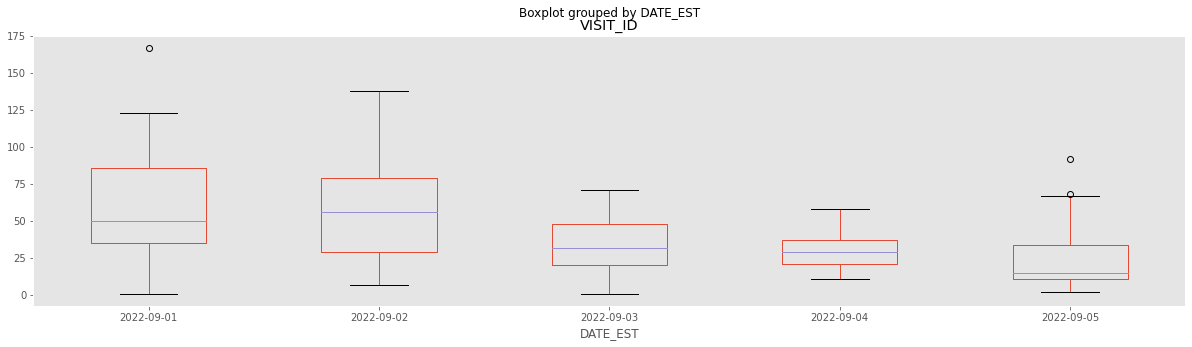

In [100]:
fig = plt.figure(figsize =(15, 7))
df_engagement_section_pageview_registered_time.boxplot(by = 'DATE_EST',column = ['VISIT_ID'],grid = False)

The highest median is on Sept 2nd. 

If we remove the outlier on Sept 1st and Sept 5th, the number of visits increased from Sept 1st to Sept 2nd but then it keeps declining.

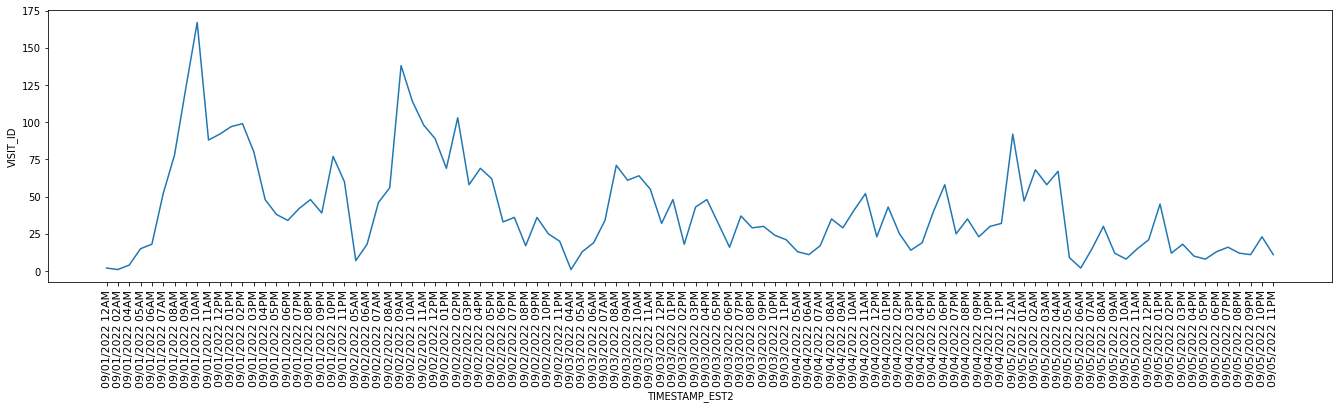

In [63]:
plt.figure(figsize=(23,5))
sns.lineplot(x = df_engagement_section_pageview_registered_time['TIMESTAMP_EST2'], y = df_engagement_section_pageview_registered_time['VISIT_ID'])
plt.xticks(rotation=90,size=11)
plt.show()

###### Create a table showing both the daily total page views as well as the day over day percent change. 

In [64]:
df_engagement_section_pageview= df_engagement2.query("EVENT_CATEGORY=='pageView'")
df_engagement_section_pageview['DATE_EST']= df_engagement_section_pageview['TIMESTAMP_EST'].apply(lambda x: x.date())
df_engagement_section_pageview['HOUR_EST']= df_engagement_section_pageview['TIMESTAMP_EST'].dt.hour
df_engagement_section_pageview['TIMESTAMP_EST2']= df_engagement_section_pageview['TIMESTAMP_EST'].apply(time_convert)
df_engagement_section_pageview['DAY_TIME_RANGE']=df_engagement_section_pageview['TIMESTAMP_EST'].apply(day_time_range)

In [65]:
df_engagement_section_pageview_day = pd.DataFrame(df_engagement_section_pageview.groupby('DATE_EST')['VISIT_ID'].count())
df_engagement_section_pageview_day['pct_change']=df_engagement_section_pageview_day.asfreq("1d").pct_change(fill_method = None).fillna(0)

In [66]:
df_engagement_section_pageview_day['percentage_change']= df_engagement_section_pageview_day['pct_change'].apply(lambda x:"{:.2%}".format(x))
df_engagement_section_pageview_day = df_engagement_section_pageview_day.rename({'VISIT_ID':"Num_of_Visits"},axis=1)
df_engagement_section_pageview_day

,Num_of_Visits,pct_change,percentage_change
DATE_EST,,,
2022-09-01,19939,0.000000,0.00%
2022-09-02,19999,0.003009,0.30%
2022-09-03,19917,-0.004100,-0.41%
2022-09-04,19875,-0.002109,-0.21%
2022-09-05,19998,0.006189,0.62%


###### Create a visualization that shows the top 10 authors by the percent of total Globe Score they contributed to for the period and what percent of total articles they wrote for the period. 

In [67]:
df_globescore_author_rank= pd.DataFrame(df_globescore_author.groupby('BYLINE')['GLOBESCORE'].sum().sort_values(ascending= False))
df_globescore_author_rank['Percentage_Globescore'] = df_globescore_author_rank['GLOBESCORE']/df_globescore_author_rank['GLOBESCORE'].sum()
df_globescore_author_rank['Percentage_Globescore']= df_globescore_author_rank['Percentage_Globescore'].apply(lambda x:"{:.2%}".format(x))
df_globescore_author_top10= df_globescore_author_rank.head(10)
# df_globescore_author_top10

In [68]:
df_globescore_author_article=pd.DataFrame(df_globescore_author.groupby('BYLINE')['ARTICLE_NUMBER'].count().sort_values(ascending= False)).reset_index()
df_globescore_author_article['Percentage_article']= df_globescore_author_article['ARTICLE_NUMBER']/df_globescore_author_article['ARTICLE_NUMBER'].sum()
df_globescore_author_article['Percentage_article'] = df_globescore_author_article['Percentage_article'].apply(lambda x:"{:.2%}".format(x))

,GLOBESCORE,Percentage_Globescore,Num_of_Articles,Percentage_article
BYLINE,,,,
ROB CARRICK,25988,1.64%,514,1.62%
BARRY HERTZ,21383,1.35%,431,1.36%
SALLY BROMPTON,19578,1.23%,388,1.22%
JOHN DOYLE,17614,1.11%,360,1.13%
BRAD WHEELER,17062,1.08%,345,1.09%
SYDNIA YU,14591,0.92%,295,0.93%
THE EDITORIAL BOARD,14581,0.92%,284,0.89%
SEAN SILCOFF,14213,0.90%,293,0.92%
BRENDA BOUW,11907,0.75%,240,0.76%


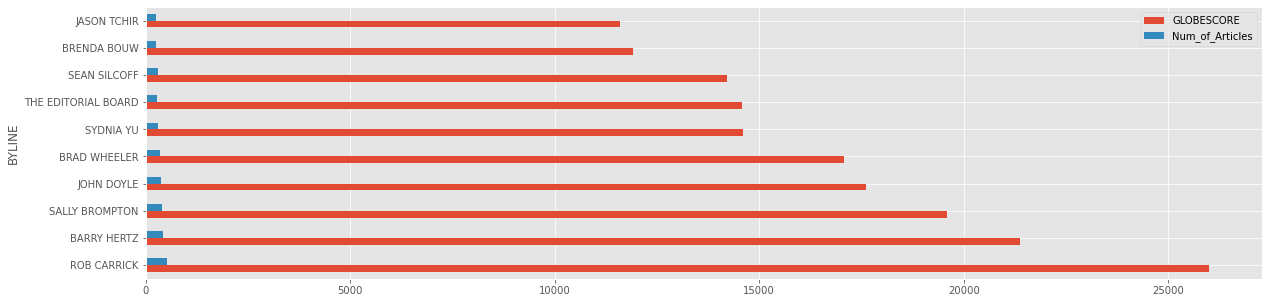

In [69]:
df_globescore_author_article_all = pd.merge(df_globescore_author_rank,df_globescore_author_article,on = 'BYLINE',how = 'left')
df_globescore_author_article_all_top10 = df_globescore_author_article_all.head(10).set_index('BYLINE')
df_globescore_author_article_all_top10
plt.rcParams["figure.figsize"] = (20, 5)
plt.style.use('ggplot')
df_globescore_author_article_all_top10 = df_globescore_author_article_all_top10.rename({'ARTICLE_NUMBER':'Num_of_Articles'},axis=1)
df_globescore_author_article_all_top10.plot.barh()
df_globescore_author_article_all_top10

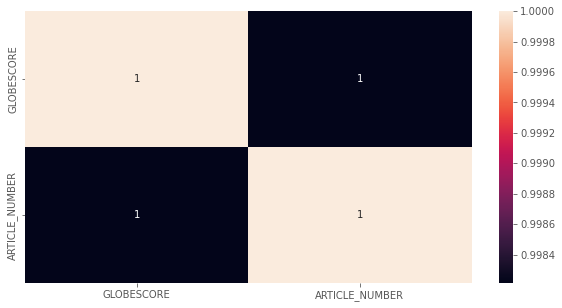

,GLOBESCORE,ARTICLE_NUMBER
GLOBESCORE,1.000000,0.998215
ARTICLE_NUMBER,0.998215,1.000000


In [70]:
corrMatrix = df_globescore_author_article_all.corr()
plt.figure(figsize = (10,5))
ax=(sns.heatmap(corrMatrix, annot=True))
plt.show()
df_globescore_author_article_all.corr()

Although Sean Silcoff wrote more articles than "the Editorial board", Sean's score is lower. 

But in general, number of articles and globalscore are strongly correlated.
The more an author writes, the higher the score he/she will get

In [71]:
df_globescore_author['PUBLISHEDAT'] = pd.to_datetime(df_globescore_author['PUBLISHEDAT'])
# df_globescore_author.info()

In [72]:
df_globescore_author['Year'] = df_globescore_author['PUBLISHEDAT'].dt.year
df_globescore_author_year = pd.DataFrame(df_globescore_author.groupby(['Year','BYLINE'])['GLOBESCORE'].sum()).reset_index()
df_globescore_author_year = df_globescore_author_year.sort_values(['Year','GLOBESCORE'],ascending = [False,False])
df_globescore_year = pd.DataFrame(df_globescore_author_year.groupby('Year')['GLOBESCORE'].sum()).reset_index()
# df_globescore_year

In [73]:
df_globescore_author_year_summary = pd.merge(df_globescore_author_year,df_globescore_year,on = 'Year',how = 'left')
df_globescore_author_year_summary = df_globescore_author_year_summary.rename({'GLOBESCORE_x':'score_author','GLOBESCORE_y':'score_year'},axis=1)
df_globescore_author_year_summary['Percentage_score_year']= df_globescore_author_year_summary['score_author']/df_globescore_author_year_summary['score_year']
df_globescore_author_year_summary['Percentage_score_year']=df_globescore_author_year_summary['Percentage_score_year'].apply(lambda x:"{:.2%}".format(x))
# df_globescore_author_year_summary.groupby('Year').head(2)

In [74]:
df_globescore_author_article_year = pd.DataFrame(df_globescore_author.groupby(['Year','BYLINE'])['ARTICLE_NUMBER'].count()).reset_index()
df_globescore_author_article_year_summary= pd.merge(df_globescore_author_year_summary,df_globescore_author_article_year,on = ['Year','BYLINE'],how = 'left')
# df_globescore_author_article_year_summary

In [75]:
df_globescore_article_count_year = pd.DataFrame(df_globescore_author.groupby('Year')['ARTICLE_NUMBER'].count()).reset_index()
df_globescore_author_article_year_summary = pd.merge(df_globescore_author_article_year_summary,df_globescore_article_count_year,on = 'Year',how = 'left')
df_globescore_author_article_year_summary = df_globescore_author_article_year_summary.rename({'ARTICLE_NUMBER_x':'article_count','ARTICLE_NUMBER_y':'article_ttl_count'},axis=1)
df_globescore_author_article_year_summary['Percentage_article_year'] = df_globescore_author_article_year_summary['article_count']/df_globescore_author_article_year_summary['article_ttl_count']
df_globescore_author_article_year_summary['Percentage_article_year'] = df_globescore_author_article_year_summary['Percentage_article_year'].apply(lambda x:"{:.2%}".format(x))
df_globescore_author_article_year_summary_top10 = df_globescore_author_article_year_summary.groupby('Year').head(10)
df_globescore_author_article_year_summary_top10
# df_globescore_author_article_year_summary_top10['Rank']= df_globescore_author_article_year_summary_top10.groupby(by=['Year'])['BYLINE'].transform(lambda x:x.rank())
# df_globescore_author_article_year_summary_top10

,Year,BYLINE,score_author,score_year,Percentage_score_year,article_count,article_ttl_count,Percentage_article_year
0,2022,SALLY BROMPTON,10821,613005,1.77%,218,12257,1.78%
1,2022,ROB CARRICK,8832,613005,1.44%,168,12257,1.37%
2,2022,THE EDITORIAL BOARD,8205,613005,1.34%,156,12257,1.27%
3,2022,SYDNIA YU,6854,613005,1.12%,138,12257,1.13%
4,2022,SCOTT BARLOW,6605,613005,1.08%,134,12257,1.09%
5,2022,BARRY HERTZ,6570,613005,1.07%,122,12257,1.00%
6,2022,BRENDA BOUW,6258,613005,1.02%,129,12257,1.05%
7,2022,DAVID LEEDER,5694,613005,0.93%,107,12257,0.87%
8,2022,JOHN DOYLE,4955,613005,0.81%,104,12257,0.85%
9,2022,JENNIFER DOWTY,4572,613005,0.75%,99,12257,0.81%


Top 10 authors per year based on article number and global score and respective percentage

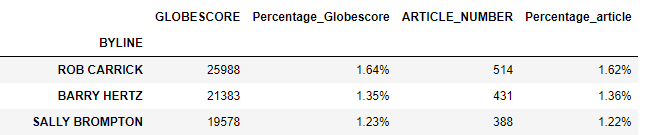

Year
2016       2
2017       3
2018    1082
2019    1378
2020    1370
2021    1985
2022    3046
Name: BYLINE, dtype: int64

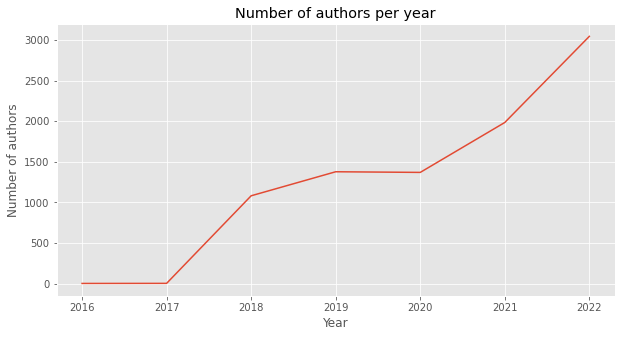

In [76]:
df_globescore_author_article_year_summary.groupby('Year')['BYLINE'].count().plot(figsize=(10,5))
plt.title('Number of authors per year')
plt.ylabel('Number of authors')
df_globescore_author_article_year_summary.groupby('Year')['BYLINE'].count()

The number of authors increased quite rapidly in 2018, steady growing through 2020.

Another increase in 2021 then jumped to a new level in 2022

In [77]:
top10_author_namelist = df_globescore_author_article_all_top10.index.to_list()
top10_author_namelist

['ROB CARRICK',
 'BARRY HERTZ',
 'SALLY BROMPTON',
 'JOHN DOYLE',
 'BRAD WHEELER',
 'SYDNIA YU',
 'THE EDITORIAL BOARD',
 'SEAN SILCOFF',
 'BRENDA BOUW',
 'JASON TCHIR']

In [78]:
df_globescore_author_count = pd.DataFrame(df_globescore_author_article_year_summary.groupby(['BYLINE','Year'])['score_author'].count().unstack().fillna(0)).reset_index()
# df_globescore_author_count.query("BYLINE == 'ROB CARRICK'")

In [79]:
df_globescore_author_total_count = pd.DataFrame(df_globescore_author_article_year_summary.groupby(['BYLINE'])['score_author'].count()).reset_index()
# df_globescore_author_total_count

In [80]:
df_globescore_author_year_count = df_globescore_author_count.query("BYLINE == @top10_author_namelist")
df_globescore_author_year_count2 = pd.merge(df_globescore_author_year_count,df_globescore_author_total_count,on = 'BYLINE',how = 'inner').set_index('BYLINE')

In [81]:
# df_globescore_author_year_count2.loc[top10_author_namelist]
df_globescore_author_year_count2.reindex(top10_author_namelist)

,2016,2017,2018,2019,2020,2021,2022,score_author
BYLINE,,,,,,,,
ROB CARRICK,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5
BARRY HERTZ,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5
SALLY BROMPTON,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5
JOHN DOYLE,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5
BRAD WHEELER,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5
SYDNIA YU,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5
THE EDITORIAL BOARD,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3
SEAN SILCOFF,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5
BRENDA BOUW,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5


Almost all top authors start to appear in the list since 2018 except for "the editorial board" who started in 2020 but gained the 7th place in the rank.

In [82]:
df_globescore_author_article_all_top10['average_score_per_article'] = round(df_globescore_author_article_all_top10['GLOBESCORE']/df_globescore_author_article_all_top10['Num_of_Articles'],3)
df_globescore_author_article_all_top10

,GLOBESCORE,Percentage_Globescore,Num_of_Articles,Percentage_article,average_score_per_article
BYLINE,,,,,
ROB CARRICK,25988,1.64%,514,1.62%,50.560
BARRY HERTZ,21383,1.35%,431,1.36%,49.613
SALLY BROMPTON,19578,1.23%,388,1.22%,50.459
JOHN DOYLE,17614,1.11%,360,1.13%,48.928
BRAD WHEELER,17062,1.08%,345,1.09%,49.455
SYDNIA YU,14591,0.92%,295,0.93%,49.461
THE EDITORIAL BOARD,14581,0.92%,284,0.89%,51.342
SEAN SILCOFF,14213,0.90%,293,0.92%,48.509
BRENDA BOUW,11907,0.75%,240,0.76%,49.612


The average score per article shows the feedback for the articles published by "the editorial board" is the top performer, ranked higher than Rob Carrick

In [83]:
df_globescore_author_article_year_count = pd.DataFrame(df_globescore_author_article_year_summary.query("BYLINE == @top10_author_namelist").groupby(['BYLINE','Year'])['article_count'].mean().unstack().fillna(0)).reset_index()
df_globescore_author_article_year_average_count = pd.DataFrame(df_globescore_author_article_year_summary.groupby(['BYLINE'])['article_count'].mean()).reset_index()
pd.merge(df_globescore_author_article_year_count,df_globescore_author_article_year_average_count,on = 'BYLINE',how='inner').sort_values(by='article_count',ascending= False)

,BYLINE,2018,2019,2020,2021,2022,article_count
5,ROB CARRICK,49.0,77.0,84.0,136.0,168.0,102.800000
9,THE EDITORIAL BOARD,0.0,0.0,40.0,88.0,156.0,94.666667
0,BARRY HERTZ,41.0,63.0,96.0,109.0,122.0,86.200000
6,SALLY BROMPTON,11.0,11.0,21.0,127.0,218.0,77.600000
4,JOHN DOYLE,34.0,44.0,75.0,103.0,104.0,72.000000
1,BRAD WHEELER,52.0,79.0,66.0,80.0,68.0,69.000000
8,SYDNIA YU,21.0,30.0,28.0,78.0,138.0,59.000000
7,SEAN SILCOFF,15.0,35.0,53.0,108.0,82.0,58.600000
2,BRENDA BOUW,19.0,31.0,26.0,35.0,129.0,48.000000
3,JASON TCHIR,38.0,54.0,45.0,59.0,43.0,47.800000


Rob carrick is the most productive author so far in average. 

The editorial board is following right after.

Sally Brompton has the best productivity in 2022. 

In [84]:
pd.merge(df_globescore_author_article_all_top10,df_globescore_author_article_year_average_count,on = 'BYLINE',how='inner')

,BYLINE,GLOBESCORE,Percentage_Globescore,Num_of_Articles,Percentage_article,average_score_per_article,article_count
0,ROB CARRICK,25988,1.64%,514,1.62%,50.560,102.800000
1,BARRY HERTZ,21383,1.35%,431,1.36%,49.613,86.200000
2,SALLY BROMPTON,19578,1.23%,388,1.22%,50.459,77.600000
3,JOHN DOYLE,17614,1.11%,360,1.13%,48.928,72.000000
4,BRAD WHEELER,17062,1.08%,345,1.09%,49.455,69.000000
5,SYDNIA YU,14591,0.92%,295,0.93%,49.461,59.000000
6,THE EDITORIAL BOARD,14581,0.92%,284,0.89%,51.342,94.666667
7,SEAN SILCOFF,14213,0.90%,293,0.92%,48.509,58.600000
8,BRENDA BOUW,11907,0.75%,240,0.76%,49.612,48.000000
9,JASON TCHIR,11592,0.73%,239,0.75%,48.502,47.800000


Rob Carrick is the star. However, the editorial board started late but was growing fast. 

It has the 2nd productivity, but top in reader's scores.

Sally Brompton and the editorial board could eventually catch up with Rob Carrick to be the top author in the coming years

###### Build reports that help stakeholders make business decisions with data. Create a dashboard that would be viewed daily that would help the organization understand key trends and KPIs. 

In [85]:
df_engagement_section_pageview_day = pd.DataFrame(df_engagement_section_pageview.groupby(['DATE_EST','DAY_TIME_RANGE'])['VISIT_ID'].count()).reset_index()
df_engagement_section_pageview_day['DAY_DETAIL']= df_engagement_section_pageview_day['DATE_EST'].astype(str) + df_engagement_section_pageview_day['DAY_TIME_RANGE'].astype(str)
df_engagement_section_pageview_day=df_engagement_section_pageview_day.rename({'VISIT_ID':'Num_of_Visits'},axis=1)
df_engagement_section_pageview_day

,DATE_EST,DAY_TIME_RANGE,Num_of_Visits,DAY_DETAIL
0,2022-09-01,AM,8388,2022-09-01AM
1,2022-09-01,PM,11551,2022-09-01PM
2,2022-09-02,AM,8260,2022-09-02AM
3,2022-09-02,PM,11739,2022-09-02PM
4,2022-09-03,AM,8875,2022-09-03AM
5,2022-09-03,PM,11042,2022-09-03PM
6,2022-09-04,AM,6423,2022-09-04AM
7,2022-09-04,PM,13452,2022-09-04PM
8,2022-09-05,AM,15161,2022-09-05AM
9,2022-09-05,PM,4837,2022-09-05PM


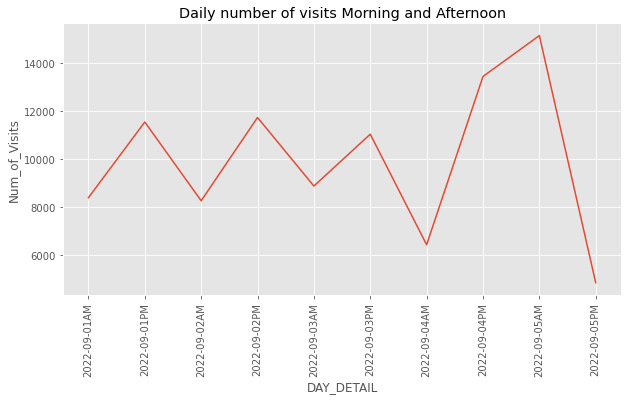

In [86]:
plt.figure(figsize=(10,5))
sns.lineplot(x = df_engagement_section_pageview_day['DAY_DETAIL'], y = df_engagement_section_pageview_day['Num_of_Visits'])
plt.title('Daily number of visits Morning and Afternoon')
plt.xticks(rotation=90,size=10)
plt.show()

In [87]:
df_engagement_section_pageview['DATE_EST']=df_engagement_section_pageview['DATE_EST'].astype(str)
df_engagement_section_pageview_2022_09_05 = df_engagement_section_pageview.query('DATE_EST.str.contains("2022-09-05")',engine='python')
df_engagement_section_pageview_2022_09_05.groupby(['DAY_TIME_RANGE','COUNTRY'])['VISIT_ID'].count().sort_values(ascending= False)

DAY_TIME_RANGE  COUNTRY
AM              CA         10389
PM              CA          4043
AM              US          2370
PM              US           583
AM              GB           404
                           ...  
                SL             1
                OM             1
                NP             1
                MZ             1
PM              ZA             1
Name: VISIT_ID, Length: 166, dtype: int64

Point 1: 

Morning volume is always lower than afternoon except for Sept 5th morning.
    
Can further investigate what happened on Sept 5th to boost views in the morning

In [88]:
df_engagement_section_pageview_device = pd.DataFrame(df_engagement_section_pageview.groupby(['PAGE_TYPE','DEVICE_TYPE'])['VISIT_ID'].count().unstack()).reset_index()
df_engagement_section_pageview_device['Total_user']= df_engagement_section_pageview_device['Computer']+df_engagement_section_pageview_device['Mobile']+df_engagement_section_pageview_device['Tablet']
df_engagement_section_pageview_device.sort_values(by = 'Total_user',ascending = False)

DEVICE_TYPE,PAGE_TYPE,Computer,Mobile,Tablet,Total_user
0,article,16531,37443,2832,56806
2,section,25161,10535,1518,37214
1,cpc,1773,3139,198,5110
3,subscription,146,426,26,598


In [89]:
df_engagement_section_device_pageview=pd.DataFrame(df_engagement_section_pageview.groupby(['DEVICE_TYPE','PAGE_TYPE'])['VISIT_ID'].count().unstack()).reset_index()
df_engagement_section_device_pageview['Total_user'] = df_engagement_section_device_pageview['article']+df_engagement_section_device_pageview['cpc']+df_engagement_section_device_pageview['section']+df_engagement_section_device_pageview['subscription']
df_engagement_section_device_pageview.sort_values(by = 'Total_user',ascending = False)

PAGE_TYPE,DEVICE_TYPE,article,cpc,section,subscription,Total_user
1,Mobile,37443,3139,10535,426,51543
0,Computer,16531,1773,25161,146,43611
2,Tablet,2832,198,1518,26,4574


Point 2: 
    
Visits using tablet is the lowest comparing with other visits through other devices.

Mobile users are a bit higher than Computer users - iOs and Android users are half-half.More users on Windows than Mac.

Format in tablet to be reviewed -- maybe tablet reading is not as user friendly as computer or mobile

Among the page types, Articles and Sections got the most visits

<AxesSubplot:xlabel='OS_FAMILY'>

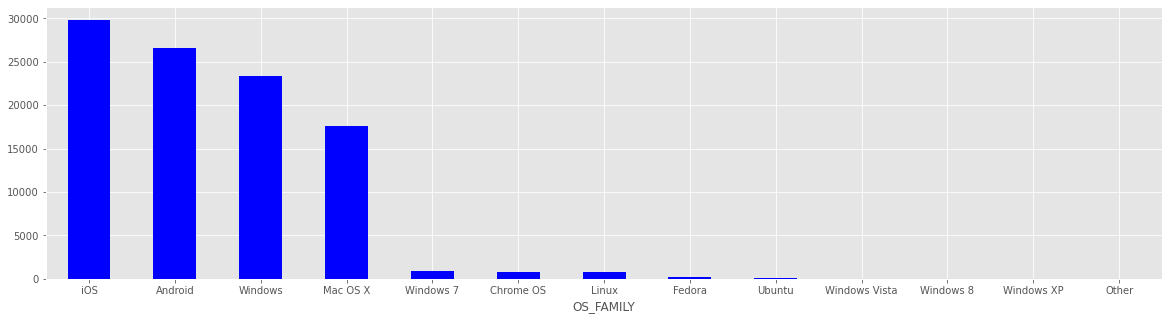

In [90]:
df_engagement.groupby('OS_FAMILY')['VISIT_ID'].count().sort_values(ascending=False).plot(kind='bar',rot=0,color='b')

In [91]:
df_engagement_country = df_engagement.dropna(subset = ['COUNTRY'])
df_engagement_country_visit = pd.DataFrame(df_engagement_country.groupby('COUNTRY')['VISIT_ID'].count().sort_values(ascending= False)).reset_index()
df_engagement_country_visit['Percentage_Visit']= df_engagement_country_visit['VISIT_ID']/df_engagement_country_visit['VISIT_ID'].sum()
df_engagement_country_visit['Percentage_Visit'] = df_engagement_country_visit['Percentage_Visit'].apply(lambda x:"{:.2%}".format(x))
df_engagement_country_visit.head()

,COUNTRY,VISIT_ID,Percentage_Visit
0,CA,81362,81.41%
1,US,12007,12.01%
2,GB,1056,1.06%
3,IN,486,0.49%
4,AU,384,0.38%


Point 3: 
    
93% visits are from Canada and USA. Canadian users are the majority. Contents seem to be more North America oriented

In [92]:
df_engagement_section_pageview_account_type = pd.DataFrame(df_engagement_section_pageview.groupby(['DATE_EST','SECTION','ACCOUNT_TYPE'])['VISIT_ID'].count().unstack().fillna(0)).reset_index()
df_engagement_section_pageview_account_type = df_engagement_section_pageview_account_type.sort_values(['DATE_EST','Anonymous User','Premium User','Registered User'],ascending = [True,False,False,False])
# df_engagement_section_pageview_account_type.groupby('DATE_EST').head(1)

In [93]:
df_engagement_section_pageview_account_type_top = df_engagement_section_pageview_account_type.groupby('DATE_EST').head(5)
df_engagement_section_pageview_account_type_top['Total_user']= df_engagement_section_pageview_account_type_top['Anonymous User']+df_engagement_section_pageview_account_type_top['Premium User']+df_engagement_section_pageview_account_type_top['Registered User']
df_engagement_section_pageview_account_type_top = df_engagement_section_pageview_account_type_top.sort_values(['DATE_EST','Total_user'],ascending= [True,False])
df_engagement_section_pageview_account_type_top = df_engagement_section_pageview_account_type_top.groupby('DATE_EST').head(1)
df_engagement_section_pageview_account_type_top

ACCOUNT_TYPE,DATE_EST,SECTION,Anonymous User,Premium User,Registered User,Total_user
20,2022-09-01,investing,2262.0,2509.0,768.0,5539.0
70,2022-09-02,investing,2147.0,2828.0,599.0,5574.0
121,2022-09-03,investing,1939.0,1692.0,240.0,3871.0
151,2022-09-04,business,2891.0,705.0,117.0,3713.0
198,2022-09-05,canada,2579.0,607.0,52.0,3238.0


In [94]:
acount_type_num_user = df_engagement.groupby('ACCOUNT_TYPE')['USER_ID_FIRST_PARTY_COOKIE'].nunique().to_dict()
acount_type_num_user

{'Anonymous User': 40424, 'Premium User': 9379, 'Registered User': 2046}

In [95]:
df_engagement_section_pageview_account_type_top['Percentage_Anonymous'] = (df_engagement_section_pageview_account_type_top['Anonymous User']/acount_type_num_user['Anonymous User']).apply(lambda x:"{:.2%}".format(x))
df_engagement_section_pageview_account_type_top['Percentage_Premium']=(df_engagement_section_pageview_account_type_top['Premium User']/acount_type_num_user['Premium User']).apply(lambda x:"{:.2%}".format(x))
df_engagement_section_pageview_account_type_top['Percentage_Registered'] = (df_engagement_section_pageview_account_type_top['Registered User']/acount_type_num_user['Registered User']).apply(lambda x:"{:.2%}".format(x))
df_engagement_section_pageview_account_type_top

ACCOUNT_TYPE,DATE_EST,SECTION,Anonymous User,Premium User,Registered User,Total_user,Percentage_Anonymous,Percentage_Premium,Percentage_Registered
20,2022-09-01,investing,2262.0,2509.0,768.0,5539.0,5.60%,26.75%,37.54%
70,2022-09-02,investing,2147.0,2828.0,599.0,5574.0,5.31%,30.15%,29.28%
121,2022-09-03,investing,1939.0,1692.0,240.0,3871.0,4.80%,18.04%,11.73%
151,2022-09-04,business,2891.0,705.0,117.0,3713.0,7.15%,7.52%,5.72%
198,2022-09-05,canada,2579.0,607.0,52.0,3238.0,6.38%,6.47%,2.54%


In [96]:
df_engagement_section_pageview_account_type['Anonymous User'].max()

2891.0

Point 4:
    
Top section per day are investing, business, canada. Should put more measures to convert users in these sections

In particular for business section which has the highest anonymous users. 

In [97]:
df_engagement_user_account_type = df_engagement2.groupby(['SECTION','ACCOUNT_TYPE'])['USER_ID_FIRST_PARTY_COOKIE'].nunique().unstack().fillna(0)
df_engagement_user_account_type['Total_registere_user'] = df_engagement_user_account_type['Premium User'] + df_engagement_user_account_type['Registered User']
df_engagement_user_account_type.describe()

ACCOUNT_TYPE,Anonymous User,Premium User,Registered User,Total_registere_user
count,60.000000,60.000000,60.000000,60.000000
mean,802.733333,313.166667,42.133333,355.300000
std,1777.826705,910.807747,135.993702,1026.659488
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000
50%,24.000000,7.500000,1.500000,10.000000
75%,269.000000,51.500000,9.500000,60.250000
max,7890.000000,5739.000000,888.000000,6228.000000


In [98]:
average_num_total_registered_user = df_engagement_user_account_type['Total_registere_user'].mean()
df_engagement_user_account_type.query("Total_registere_user<=@average_num_total_registered_user").sort_values(by ='Anonymous User',ascending=False ).head()

ACCOUNT_TYPE,Anonymous User,Premium User,Registered User,Total_registere_user
SECTION,,,,
globeandmail,3990.0,46.0,12.0,58.0
news,884.0,8.0,2.0,10.0
drive,828.0,221.0,19.0,240.0
politics,353.0,160.0,9.0,169.0
podcasts,241.0,65.0,2.0,67.0


Point 5:

globeandmail,news has relatively higher anonymous users but total registered users are below the average, especially
globeandmail. Sales might need to put measures to convert anonymous users in these two sections

These sections below have total registered_user less than 10 but also not many in anonymous users to be evaluated if 
certain sections should just be removed

In [99]:
df_engagement_user_account_type.query("Total_registere_user<10").sort_values(by ='Anonymous User',ascending=False )

ACCOUNT_TYPE,Anonymous User,Premium User,Registered User,Total_registere_user
SECTION,,,,
globedrive,164.0,0.0,0.0,0.0
reportonbusiness,99.0,0.0,0.0,0.0
realestate,65.0,0.0,0.0,0.0
globeinvestor,35.0,0.0,0.0,0.0
technology,24.0,1.0,0.0,1.0
newsrelease,17.0,1.0,0.0,1.0
featuredreports,14.0,1.0,0.0,1.0
partners,11.0,0.0,0.0,0.0
betterinformed,9.0,1.0,0.0,1.0
